# Tracking Machine Learning Experiments with MLflow and Dockerizing Trained Models: Germany Car Price Prediction Case Study

MLflow is a comprehensive platform developed to streamline the end-to-end machine learning (ML) lifecycle. It offers several key components, including the recording of parameters and metrics, managing models with support for various ML libraries, facilitating model development through the Model Registry, and enabling deployment to cloud services while serving models via REST API endpoints. In this case study, we leverage MLflow to track an experiment focused on predicting the prices of German cars.

The dataset utilized for this experiment is the [Germany Cars Dataset](https://www.kaggle.com/datasets/ander289386/cars-germany). We employ XGBoost, an efficient and popular machine learning ensemble algorithm, to train a model on the dataset. Given the numerous parameters of XGBoost, we use [Hyperopt](http://hyperopt.github.io/hyperopt/) or hyperparameter optimization, though our code can easily accommodate other optimization libraries like [Optuna](https://optuna.org/). 

Let's import the necessary libraries for reading and preprocessing the dataset, training models, and optimizing hyperparameters.


In [86]:
from pathlib import Path
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from mlflow.models import infer_signature
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


## MLflow Server
An MLflow tracking server is used for monitoring our experiment and logging parameters and metrics. We assumes the URI of the MLflow server to be `http://localhost:8080`. If you are using a different server or port, you can modify the URI.


In [87]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

## Preprocessing and Cleaning the Dataset

In [74]:
dataset_path = Path('./data/autoscout24-germany-dataset.csv')
df = pd.read_csv(dataset_path)

df.head()

,mileage,make,model,fuel,gear,offerType,price,hp,year
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,2011
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,2011
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,2011
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,2011
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,2011


We remove rows with missing values. Additionally, since the dataset was collected in 2021, we convert the `year` column, representing the production year of cars, to the `age` of the cars.

In [75]:
df.dropna(inplace=True)
df['age'] = df['year'].apply(lambda x: 2021-x)
df.drop(columns=['year'], inplace=True)

We perform further cleaning by removing rare categories. Additionally, we will exclude cars whose `make` and `model` have fewer than 50 occurrences in the dataset.

In [76]:
df.drop(index=df[df['offerType']=='New'].index, inplace=True) #removes 13 rows

#removes all cars with `fuel` other than Diesel and Gasoline, Electric/Gasoline, Electric
fuel_types = ['Diesel', 'Gasoline', 'Electric/Gasoline', 'Electric']
df = df[df['fuel'].isin(fuel_types)]

# remove 56 rows where `gear`=='Semi-automatic'
df = df[df['gear']!='Semi-automatic']

df = df[df.groupby(['make', 'model']).transform('size')>=50]

The dataset comprises both numerical and categorical variables. While machine learning libraries might be able to handle categorical variables, it's good practice to explicitly define the type of these columns in the dataframe as `category`.

In [77]:
categorical_cols = ['make', 'model', 'fuel', 'gear', 'offerType']
df = pd.concat([df[[c for c in df.columns if c not in categorical_cols]], df[categorical_cols].astype('category')], axis=1)

There are two variable in the dataset that has a very wide range, `price`, which is the target variable, and `mileage`. When a variable has a very wide range, it usually makes sense to transform it to the logarithmic scale.

Let's examine `price` first. After comparing two plots, we conclude that working with `log(price)` is probably a better choice.

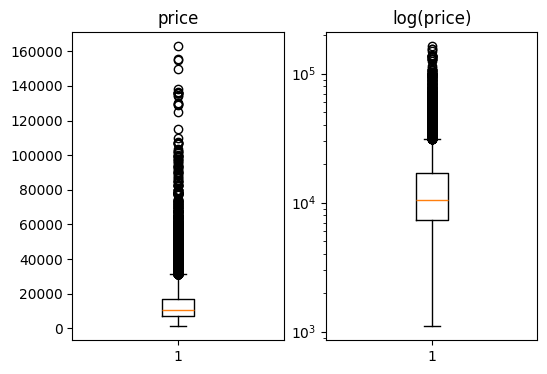

In [78]:
fig, axs = plt.subplots(1,2, figsize=(6,4))
axs[0].boxplot(df['price'])
axs[0].set_title('price')
axs[1].boxplot(df['price'])
axs[1].set_yscale('log')
_ = axs[1].set_title('log(price)')

How about `mileage`? The following plot indicates that using `log(mileage)` instead of `mileage` directly may be better, too.

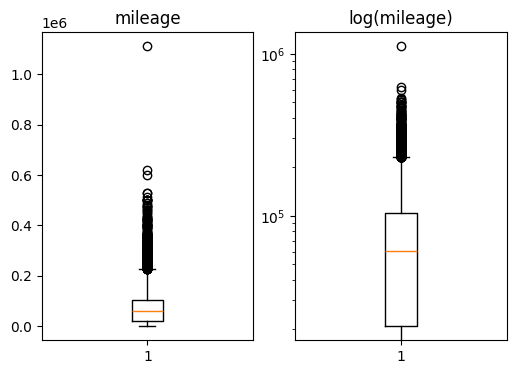

In [79]:
fig, axs = plt.subplots(1,2, figsize=(6,4))
axs[0].boxplot(df['mileage'])
axs[0].set_title('mileage')
axs[1].boxplot(df['mileage'])
axs[1].set_yscale('log')
_ = axs[1].set_title('log(mileage)')

However, it's a good idea to examine the relationship between `mileage`, an independent variable in our experiment, and `price`, our dependent variable. Ignoring extreme cases, we analyze the relation between the two variables for the majority of cars. We fit a line to the log plot of the two variables, resulting in a slope of -0.3. Although the plot doesn't show a perfect linear relationship between the two variables, I am convinced that using `log(mileage)` instead of `mileage` would be more appropriate.

array([-0.29550244,  5.42772771])

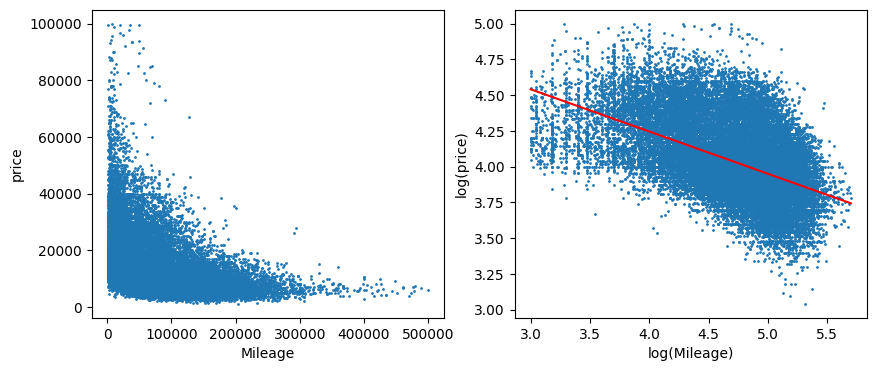

In [96]:
df_tmp = df[(df['mileage']>1000)&(df['mileage']<500000)&(df['price']<100000)].copy()

df_tmp['mileage_log'] = df_tmp['mileage'].apply(math.log10)
df_tmp['price_log'] = df_tmp['price'].apply(math.log10)

fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].scatter(df_tmp['mileage'], df_tmp['price'], s=1)
axs[0].set_xlabel('Mileage')
axs[0].set_ylabel('price')

axs[1].scatter(df_tmp['mileage_log'], df_tmp['price_log'], s=1)
axs[1].set_xlabel('log(Mileage)')
axs[1].set_ylabel('log(price)')

cs = np.polyfit(df_tmp['mileage_log'], df_tmp['price_log'], deg=1)
x = np.linspace(math.log10(1000),math.log10(500000),10)
axs[1].plot(x, np.polyval(cs, x), color='red')
cs

Thus, we include two new columns, `price_log` and `mileage_log`, in our dataframe and save it. With that, we've completed preprocessing and cleaning the dataset.

In [81]:
df['price_log'] = df['price'].apply(math.log10)
df['mileage_log'] = df['mileage'].apply(lambda x: 0 if x==0 else math.log10(x))

dataset_path = Path('./data/autoscout24-germany-dataset-cleaned.csv')
df.to_csv(dataset_path)


## XGBoost

In this section, we define a class that includes a pipeline for preprocessing categorical variables and an XGBoost model, and the search space for hyperparameters. We optimize four parameters for XGBoost:
1. `max_depth`
2. `subsample`
3. `learning_rate`
4. `min_child_weight`

For a better understanding of these parameters, refer to the [XGBoost documentation](https://xgboost.readthedocs.io).

In [82]:
class XGBModelPipline:
    def __init__(self, categorical_cols):
        self.categorical_cols = categorical_cols

    def get_model(self, params):
        # build a pipeline
        ordinal_encoder = preprocessing.OrdinalEncoder()
        preprocess = ColumnTransformer(
            [("Ordinal-Encoder", ordinal_encoder, self.categorical_cols)],
            remainder="passthrough",
        )
        xgb_model = xgb.XGBRegressor(**params)
        model = Pipeline([("preprocess", preprocess), ("xgb_model", xgb_model)])
        return model

    def get_space(self):
        # the space for searching for the best parameter setting
        space = {
            "max_depth": hp.uniformint("max_depth", 2, 8),
            "subsample": hp.quniform("subsample", 0.5, 1, 0.1),
            "learning_rate": hp.loguniform("learning_rate", np.log(1e-5), np.log(1e-1)),
            "min_child_weight": hp.uniformint("min_child_weight", 1, 5),
        }
        return space


## Hyperparameter Optimization and Experiment Monitoring with MLflow

The `HyperparameterOptimizer` class accepts the training and validation datasets, trains a model for each parameter setting, and records parameters, metrics, and models using MLflow. This class offers flexibility to adjust additional parameters, which in turn allows experimentation with other models and datasets.

In [83]:
class HyperparameterOptimizer:
    def __init__(
        self,
        model,
        train_x,
        train_y,
        val_x,
        val_y,
        experiment_name,
        artifact_path,
        registered_model_name,
        evaluator=mean_squared_error,
        evaluator_name="mse",
        max_evals=100,
    ):
        self.model = model
        self.train_x = train_x
        self.train_y = train_y
        self.val_x = val_x
        self.val_y = val_y
        self.evaluator = evaluator
        self.evaluator_name = evaluator_name
        self.max_evals = max_evals
        self.experiment_name = experiment_name
        self.artifact_path = artifact_path
        self.registered_model_name = registered_model_name
        self.signature = infer_signature(train_x[:1], train_y[:1])

    def train_model(self, params):
        model = self.model.get_model(params)

        # Train model with MLflow tracking
        with mlflow.start_run(nested=True):
            _ = model.fit(self.train_x, self.train_y)

            # Evaluattion
            pred_y = model.predict(self.val_x)
            eval_metric = self.evaluator(self.val_y, pred_y)

            # Log the parameters, metric and model
            mlflow.log_params(params)
            mlflow.log_metric(self.evaluator_name, eval_metric)
            mlflow.sklearn.log_model(
                model, artifact_path=self.artifact_path, signature=self.signature
            )
            result = {"loss": eval_metric, "status": STATUS_OK, "model": model}
            return result

    def objective(self, params):
        # the objective function builds a new model for each parameter setting and MLFlow trackes parameters and results
        result = self.train_model(params)
        return result

    def run_experiment(self):
        mlflow.set_experiment(self.experiment_name)
        with mlflow.start_run():
            # Conduct the hyperparameter search using Hyperopt
            trials = Trials()
            best_parameters = fmin(
                fn=self.objective,
                space=self.model.get_space(),
                algo=tpe.suggest,
                max_evals=self.max_evals,
                trials=trials,
            )

            # find the best model
            best_trial = sorted(trials.results, key=lambda x: x["loss"])[0]

            # Log the best parameters, MSE, and model
            mlflow.log_params(best_parameters)
            mlflow.log_metric(self.evaluator_name, best_trial["loss"])

            best_model_info = mlflow.sklearn.log_model(
                best_trial["model"],
                artifact_path=self.artifact_path,
                signature=self.signature,
                input_example=self.train_x,
                registered_model_name=self.registered_model_name,
            )
        return best_parameters, best_trial, best_model_info.model_uri


The following function loads the cleaned dataset and splits it into train (70%), validation (15%), and test (15%) sets.

In [84]:
def load_dataset(path):
    df = pd.read_csv(path)
    categorical_cols = ["make", "model", "fuel", "gear", "offerType"]
    numerical_cols = ["mileage_log", "hp", "age", "price_log"]

    cols = categorical_cols + numerical_cols
    data = df[cols]

    train, val_and_test = train_test_split(data, test_size=0.30, random_state=37)
    train_x = train.drop(["price_log"], axis=1)
    train_y = train[["price_log"]]

    val, test = train_test_split(val_and_test, test_size=0.50, random_state=37)
    val_x = val.drop(["price_log"], axis=1)
    val_y = val[["price_log"]]
    test_x = test.drop(["price_log"], axis=1)
    test_y = test[["price_log"]]
    return (
        train_x,
        train_y,
        val_x,
        val_y,
        test_x,
        test_y,
        categorical_cols,
        numerical_cols,
    )

Now, we can run the experiment. The metric that we use for evaluation is mean squared error (MSE). The following code prints the best parameters found and the MSE for the best model. We use the validation set for hyperparameter optimization. Finally, we evaluate the best model found on the test set.

In [99]:
dataset_path = Path("./data/autoscout24-germany-dataset-cleaned.csv")
train_x, train_y, val_x, val_y, test_x, test_y, categorical_cols, _ = load_dataset(
    dataset_path
)

# defining the hyperparameter optimizer object and running the experiment
hyperparmeter_finder = HyperparameterOptimizer(
    XGBModelPipline(categorical_cols),
    train_x,
    train_y,
    val_x,
    val_y,
    experiment_name="german-car-price",
    artifact_path="german_car_model",
    registered_model_name="german-car-price-best-model"
)
best_parameters, best_trail, model_uri = hyperparmeter_finder.run_experiment()

print(f"Parameters of the best model: {best_parameters}")
print(
    f"Mean squared error (MSE) of the best model on the validation dataset: {best_trail['loss']}"
)

# loading the best model and testing its performance with the test dataset
loaded_model = mlflow.sklearn.load_model(model_uri)
predictions = loaded_model.predict(test_x)
test_mse = mean_squared_error(test_y, predictions)
print(f"Mean squared error (MSE) of the best model on the test dataset: {test_mse}")

2024/04/26 16:35:47 INFO mlflow.tracking.fluent: Experiment with name 'german-car-price' does not exist. Creating a new experiment.


100%|██████| 100/100 [03:14<00:00,  1.95s/trial, best loss: 0.0034344412938926735]


Successfully registered model 'german-car-price-best-model'.
2024/04/26 16:39:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: german-car-price-best-model, version 1
Created version '1' of model 'german-car-price-best-model'.


Parameters of the best model: {'learning_rate': 0.09083849572319974, 'max_depth': 8.0, 'min_child_weight': 1.0, 'subsample': 0.7000000000000001}
Mean squared error (MSE) of the best model on the validation dataset: 0.0034344412938926735


Mean squared error (MSE) of the best model on the test dataset: 0.0033066927390697303


## Serve the Model
The registered model can be served using:
```
mlflow models serve -m "models:/german-car-price-best-model/1" --port 5002
```

You may need to first run:
```
export MLFLOW_TRACKING_URI=http://localhost:8080
```

To test the model, requests can be sent to the REST API using the curl command:
```
curl -d '{"dataframe_split": { "columns": ["make", "model", "fuel", "gear", "offerType", "mileage_log", "hp", "age"], "data": [["BMW", "118",   "Diesel", "Manual", "Used", 5.019116, 143.0, 10]]}}' -H 'Content-Type: application/json' -X POST localhost:5002/invocations
```

which returns the following result:
```
{"predictions": [3.950029134750366]}
```

As the model is trained to predict the logarithm of price, the output is in logarithmic scale and should be converted back using `10**prediction`.

## Build a Docker Image for the Model
To create a docker image for the registered model, use:
```
mlflow models build-docker --model-uri "models:/german-car-price-best-model/1" --name "german-car-price"
```

The docker image created, named `german-car-price`, can later be run locally, on a server, or on a cloud. To run the docker image locally, you can use this command:
```
docker run -p 5002:8080 german-car-price
```